# Kernel Density Estimation and histograms
* Histograms are non-parametric method (i.e. they do not make assumptions on the underlying distribution of the data) to study discrete data. 

* KDE is a method to interpret those data by applying a kernel of various sizes and adding the overlapping points. We can use: boxy, Gaussian etc kernels. 

* The appropriate bin-size of the histograms is given by:
    * Freedaman-Diaconis rule (good for univariate, outliers| bad for uniform and multivariate)
    * Scott+92 (assuming normal distribution, bad with outliers)
    * Shimazaki+07 (assumed Poissonian distribution)
    * Knuth+06 (uses Bayesian inference)
    
Below we have an example from https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

In [70]:
# Importing Libraries
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from sklearn.grid_search import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print "Package Versions:"
import sklearn; print "  scikit-learn:", sklearn.__version__
import scipy; print "  scipy:", scipy.__version__
import statsmodels; print "  statsmodels:", statsmodels.__version__

Package Versions:
  scikit-learn: 0.19.1
  scipy: 1.0.0
  statsmodels: 0.8.0


In [66]:
# Define various KDE functions

def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, var_type='c', bw=bandwidth * np.ones_like(x), **kwargs)
    return kde.pdf(x_grid)

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Scipy', 'Scikit-learn']
# kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
# kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

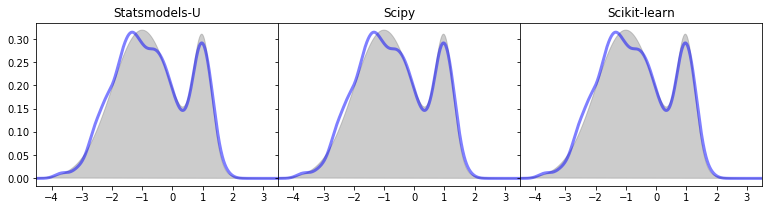

In [67]:
# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 3, sharey=True,
                          figsize=(13, 3))
# fig, ax = plt.subplots(1, 4, sharey=True,
#                           figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(len(kde_funcs)):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='grey'>Gray = True underlying distribution</font><br>"
     "<font color='blue'>Blue = KDE model distribution (500 pts)</font>")

The selection of bandwidth is an important piece of KDE. For the same input data, different bandwidths can produce very different results:

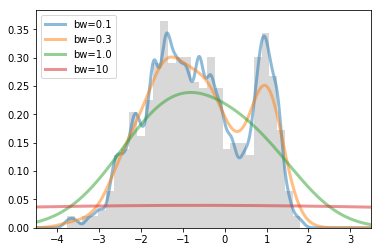

In [72]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0,10]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')

So to select the right bandwidth we use the cross validation within Scikit-learn which is straightforward with the GridSearchCV meta-estimator:

{'bandwidth': 0.19310344827586207}


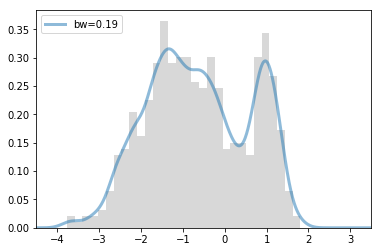

In [75]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 1.0, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print grid.best_params_

kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))

fig, ax = plt.subplots()
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.legend(loc='upper left')
ax.set_xlim(-4.5, 3.5);

# Example
Check out this site for comparison of KDE implementations in python: 
https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

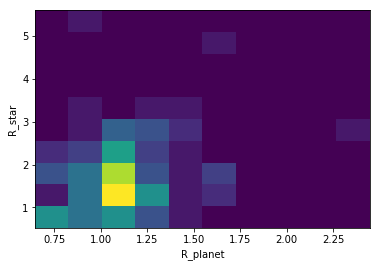

In [107]:
# Load in stellar radius data from the previous catalog of exoplanets
x = np.genfromtxt('data/J_ApJ_770_69/table2.dat', delimiter = '|', usecols = (12,13))

plt.hist2d(x[:,0],x[:,1],bins=10)
plt.xlabel('R_planet')
plt.ylabel('R_star')
plt.show()